# Class Activation Mapping Visualization

## 2018

### 1. Introduction

__Reference__: [Learning Deep Features for Discriminative Localization](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)<font>

> Zhou B, Khosla A, Lapedriza A, et al. Learning deep features for discriminative localization[C]//Computer Vision and Pattern Recognition (CVPR), 2016 IEEE Conference on. IEEE, 2016: 2921-2929.<font>

The convolutional units of various layers of convolutional neural networks (CNNs) actually behave as object detectors despite no supervision on the location of the object was provided.

But this ability is lost when fully-connected layers are used for classification. Using Global Average Pooling layer instead of FC-layers can minimize the number of parameters while maintaining high performance on recognition.

Meanwhile, GAP can retain its remarkable localization ability until the final layer.

### 2. Class Activation Mapping

![CAM](./CAM.png)
<center>Class Activation Mapping<center>

We can perform GAP on the convolutional feature maps and use those as features for fully-connected layer that produces the desired output, and we can identify the importance of the image regions by projecting back the weights of the output layer on to the convolutional feature maps.<font>

<br>

### 3. Implement on Keras

Load Data

In [1]:
import sys
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
n_train = 25000
height = 224
width = 224

train = np.zeros((n_train, height, width, 3), dtype=np.uint8)
labels = np.zeros((n_train, 2), dtype=np.uint8)

labels[:n_train/2, 0] = 1
labels[n_train/2:, 1] = 1

In [3]:
for i in tqdm(range(12500)):
    tmp = cv2.imread('../Data/train/' + 'cat.%s.jpg' %(str(i)))
    tmp = tmp[:, :, ::-1]
    tmp = cv2.resize(tmp, (height, width))
    train[i] = tmp
    
for i in tqdm(range(12500)):
    tmp = cv2.imread('../Data/train/' + 'dog.%s.jpg' %(str(i)))
    tmp = tmp[:, :, ::-1]
    tmp = cv2.resize(tmp, (height, width))
    train[i+12500] = tmp

100%|██████████| 12500/12500 [00:27<00:00, 458.34it/s]


In [4]:
print('Training Set Size: %.2f M' %(sys.getsizeof(train) / 1024 / 1024))

Training Set Size: 3588.00 M


Extract Feature Vectors

In [5]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

Using TensorFlow backend.


In [6]:
np.random.seed(20)


input_tensor = Input((224, 224, 3))
x = input_tensor
x = Lambda(resnet50.preprocess_input)(x)

base_model = ResNet50(input_tensor=x, weights='imagenet', 
                      include_top=False)
y = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=y)
model.compile(optimizer='adadelta', loss='binary_crossentropy', 
              metrics=['accuracy'])

features = model.predict(train, batch_size=64, verbose=1)

25000/25000 [==============================] - 215s 9ms/step


Using Transfer Learning

In [7]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adadelta', loss='binary_crossentropy', 
              metrics=['accuracy'])
history = model.fit(features, labels, batch_size=16, epochs=10, 
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 6s 277us/step - loss: 0.0708 - acc: 0.9745 - val_loss: 0.0354 - val_acc: 0.9860
Epoch 2/10
20000/20000 [==============================] - 5s 247us/step - loss: 0.0419 - acc: 0.9859 - val_loss: 0.0495 - val_acc: 0.9824
Epoch 3/10
20000/20000 [==============================] - 5s 246us/step - loss: 0.0385 - acc: 0.9874 - val_loss: 0.0418 - val_acc: 0.9856
Epoch 4/10
20000/20000 [==============================] - 5s 249us/step - loss: 0.0380 - acc: 0.9876 - val_loss: 0.0737 - val_acc: 0.9770
Epoch 5/10
20000/20000 [==============================] - 5s 239us/step - loss: 0.0416 - acc: 0.9887 - val_loss: 0.0343 - val_acc: 0.9898
Epoch 6/10
20000/20000 [==============================] - 4s 219us/step - loss: 0.0405 - acc: 0.9874 - val_loss: 0.0530 - val_acc: 0.9850
Epoch 7/10
20000/20000 [==============================] - 5s 236us/step - loss: 0.0370 - acc: 0.9885 - val_loss: 0.0350 - v

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________


In [9]:
weights = model.get_weights()[0]

In [10]:
CNNModel = ResNet50(include_top=False, input_shape=(height, width, 3), 
                    weights='imagenet')
CNNModel = Model(CNNModel.input, CNNModel.layers[-2].output)

input_tensor = Input((height, width, 3))
x = input_tensor
x = CNNModel(x)
CAM = Conv2D(2, 1, use_bias=False, name='cam')(x)
CAMModel = Model(input_tensor, CAM)

x = GlobalAveragePooling2D()(x)
x = model(x)
model_clf = Model(input_tensor, x)

In [11]:
CAMModel.layers[-1].set_weights([weights.reshape((1, 1, 2048, 2))])

Predict

Text(0.5,1,u'CAT 99.97%')

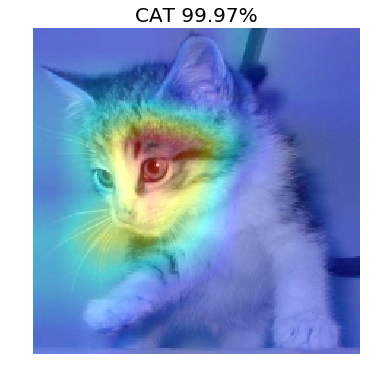

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

index = np.random.randint(n_train)
img = train[index]

pred = model_clf.predict(np.expand_dims(img, 0))
pred = pred[0, 0]

CAM = CAMModel.predict(np.expand_dims(img, 0))
CAM = CAM[0, :, :, 1 if pred < 0.5 else 0]

CAM = (CAM - CAM.min()) / (CAM.max() - CAM.min())
CAM = cv2.resize(CAM, (224, 224))
CAM = np.uint8(CAM * 255.0)

heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)

if pred > 0.5:
    text = 'CAT %.2f%%' %(pred * 100.0)
else:
    text = 'DOG %.2f%%' %(100.0 - (pred * 100.0))

fig = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
plt.figure(figsize=(6, 6))
plt.imshow(fig[:, :, ::-1])
plt.axis('off')
plt.title(text, fontsize=20)


## Acknowledgement

* https://github.com/ypwhs/CAM